%%<br>
For tips on running notebooks in Google Colab, see<br>
https://pytorch.org/tutorials/beginner/colab

In [1]:
%matplotlib inline

%% [markdown]<br>
Transfer Learning for Computer Vision Tutorial<br>
==============================================<br>
<br>
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)<br>
<br>
In this tutorial, you will learn how to train a convolutional neural<br>
network for image classification using transfer learning. You can read<br>
more about the transfer learning at [cs231n<br>
notes](https://cs231n.github.io/transfer-learning/)<br>
<br>
Quoting these notes,<br>
<br>
> In practice, very few people train an entire Convolutional Network<br>
> from scratch (with random initialization), because it is relatively<br>
> rare to have a dataset of sufficient size. Instead, it is common to<br>
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which<br>
> contains 1.2 million images with 1000 categories), and then use the<br>
> ConvNet either as an initialization or a fixed feature extractor for<br>
> the task of interest.<br>
<br>
These two major transfer learning scenarios look as follows:<br>
<br>
-   **Finetuning the ConvNet**: Instead of random initialization, we<br>
    initialize the network with a pretrained network, like the one that<br>
    is trained on imagenet 1000 dataset. Rest of the training looks as<br>
    usual.<br>
-   **ConvNet as fixed feature extractor**: Here, we will freeze the<br>
    weights for all of the network except that of the final fully<br>
    connected layer. This last fully connected layer is replaced with a<br>
    new one with random weights and only this layer is trained.<br>


%%<br>
License: BSD<br>
Author: Sasank Chilamkurthy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR

In [3]:
cudnn.benchmark = True
plt.ion()   # interactive mode

%% [markdown]<br>
Load Data<br>
=========<br>
<br>
We will use torchvision and torch.utils.data packages for loading the<br>
data.<br>
<br>
The problem we\'re going to solve today is to train a model to classify<br>
**ants** and **bees**. We have about 120 training images each for ants<br>
and bees. There are 75 validation images for each class. Usually, this<br>
is a very small dataset to generalize upon, if trained from scratch.<br>
Since we are using transfer learning, we should be able to generalize<br>
reasonably well.<br>
<br>
This dataset is a very small subset of imagenet.<br>


%%

In [4]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


%%

In [5]:
num_epochs = 200
lr=0.001
momentum=0.9
step_size=7 
gamma=0.1
weight_decay=1e-4
batch_size=16
patience=20
warmup_epochs = 10

%%

Load the .npy dataset

In [6]:
path_to_fer = 'fer13_v2.npy'
m = np.load(path_to_fer, allow_pickle=True).item()
x_train, y_train = m['train']
x_val, y_val = m['val']
x_test, y_test = m['test']

Define custom dataset class

In [7]:
class FERDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.uint8)
        label = int(self.labels[idx])  # Ensure label is an integer
        return self.transform(image), label

Define transformations

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Resize from 48x48 to 224x224
        transforms.Grayscale(num_output_channels=3),  # Convert 1-channel to 3-channel
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize for grayscale
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Resize from 48x48 to 224x224
        transforms.Grayscale(num_output_channels=3),  # Convert 1-channel to 3-channel
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize for grayscale
    ]),
}

Create datasets

In [9]:
datasets = {
    'train': FERDataset(x_train, y_train, transform=data_transforms['train']),
    'val': FERDataset(x_val, y_val, transform=data_transforms['val']),
    'test': FERDataset(x_test, y_test, transform=data_transforms['val'])
}

Create dataloaders

In [10]:
dataloaders = {
    x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True)
    for x in ['train', 'val', 'test']
}

In [11]:
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

Get the number of unique classes in the dataset

In [12]:
num_classes = len(np.unique(np.concatenate([y_train, y_val, y_test])))

In [13]:
print(f"Number of classes: {num_classes}")

Number of classes: 7


Select device

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


%%

In [15]:
dataset_sizes

{'train': 28709, 'val': 3589, 'test': 3589}

%% [markdown]<br>
Visualize a few images<br>
======================<br>
<br>
Let\'s visualize a few training images so as to understand the data<br>
augmentations.<br>


%%

In [16]:
# def show_sample_images(dataloader, num_images=6):
#     images_shown = 0
#     fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
#     for images, labels in dataloader:
#         for i in range(num_images):
#             image = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
#             axes[i].imshow(image, cmap='gray')
#             axes[i].set_title(f"Label: {labels[i]}")
#             axes[i].axis('off')
#             images_shown += 1
#             if images_shown >= num_images:
#                 plt.show()
#                 return
            
# # Show sample images
# show_sample_images(dataloaders['train'])

%% [markdown]<br>
Training the model<br>
==================<br>
<br>
Now, let\'s write a general function to train a model. Here, we will<br>
illustrate:<br>
<br>
-   Scheduling the learning rate<br>
-   Saving the best model<br>
<br>
In the following, parameter `scheduler` is an LR scheduler object from<br>
`torch.optim.lr_scheduler`.<br>


%%

Define training function

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    since = time.time()
    
    # Create models directory
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    best_model_path = os.path.join(model_dir, 'best_model.pth')
    
    best_acc = 0.0
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step()
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_path)
                patience_counter = 0  # Reset early stopping counter
            elif phase == 'val':
                patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model
    model.load_state_dict(torch.load(best_model_path))
    
    # Plot training results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')
    
    plt.show()
    
    return model

%% [markdown]<br>
Visualizing the model predictions<br>
=================================<br>
<br>
Generic function to display predictions for a few images<br>


%%<br>
Function to unnormalize and show an image

In [18]:
def imshow(img):
    """Display a tensor image (Grayscale or RGB)"""
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor format (C, H, W) to (H, W, C)
    img = img * 0.5 + 0.5  # Unnormalize (assuming Normalize([0.5], [0.5]))
    
    if img.shape[-1] == 1:  # If the image is grayscale, remove the last dimension
        img = img.squeeze(-1)
    
    plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)  # Use 'gray' colormap if grayscale
    plt.axis("off")

Function to visualize model predictions

In [19]:
def visualize_model(model, num_images=6):
    """Visualizes model predictions on the validation set"""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, num_images * 2))
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot((num_images + 1) // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f'Predicted: {preds[j].item()} | True: {labels[j].item()}')
                
                imshow(inputs.cpu().data[j])  # Show image
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

%% [markdown]<br>
Finetuning the ConvNet<br>
======================<br>
<br>
Load a pretrained model and reset final fully connected layer.<br>


%%

In [20]:
model_ft = models.efficientnet_b0(weights="IMAGENET1K_V1")
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)

Freeze all parameters except classifier[1] (last layer)

In [21]:
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.classifier[1].parameters():
    param.requires_grad = True

In [22]:
model_ft = model_ft.to(device)

Define loss function for 7-class classification

In [23]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for better generalization

Define optimizer

In [24]:
optimizer_ft = optim.Adam(model_ft.parameters(), lr=lr, weight_decay=weight_decay)

Learning rate warmup & cosine annealing

In [25]:
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    return 0.5 * (1 + torch.cos(torch.tensor((epoch - warmup_epochs) / (num_epochs - warmup_epochs) * 3.141592)))

In [26]:
scheduler = LambdaLR(optimizer_ft, lr_lambda=lr_lambda)

%% [markdown]<br>
Train and evaluate<br>
==================<br>
<br>
It should take around 15-25 min on CPU. On GPU though, it takes less<br>
than a minute.<br>


%%

Run training

Epoch 0/199
----------
train Loss: 1.7483 Acc: 0.3310
val Loss: 1.6698 Acc: 0.3962

Epoch 1/199
----------
train Loss: 1.6509 Acc: 0.3932
val Loss: 1.6019 Acc: 0.4347

Epoch 2/199
----------
train Loss: 1.6141 Acc: 0.4123
val Loss: 1.5748 Acc: 0.4444

Epoch 3/199
----------
train Loss: 1.5952 Acc: 0.4247
val Loss: 1.5597 Acc: 0.4475

Epoch 4/199
----------
train Loss: 1.5900 Acc: 0.4236
val Loss: 1.5634 Acc: 0.4461

Epoch 5/199
----------
train Loss: 1.5875 Acc: 0.4259
val Loss: 1.5635 Acc: 0.4475

Epoch 6/199
----------
train Loss: 1.5889 Acc: 0.4266
val Loss: 1.5412 Acc: 0.4600

Epoch 7/199
----------
train Loss: 1.5937 Acc: 0.4269
val Loss: 1.5632 Acc: 0.4447

Epoch 8/199
----------
train Loss: 1.6021 Acc: 0.4216
val Loss: 1.5567 Acc: 0.4609

Epoch 9/199
----------
train Loss: 1.6049 Acc: 0.4216
val Loss: 1.5681 Acc: 0.4486

Epoch 10/199
----------
train Loss: 1.6098 Acc: 0.4193
val Loss: 1.5712 Acc: 0.4503

Epoch 11/199
----------
train Loss: 1.6079 Acc: 0.4212
val Loss: 1.5887 Acc

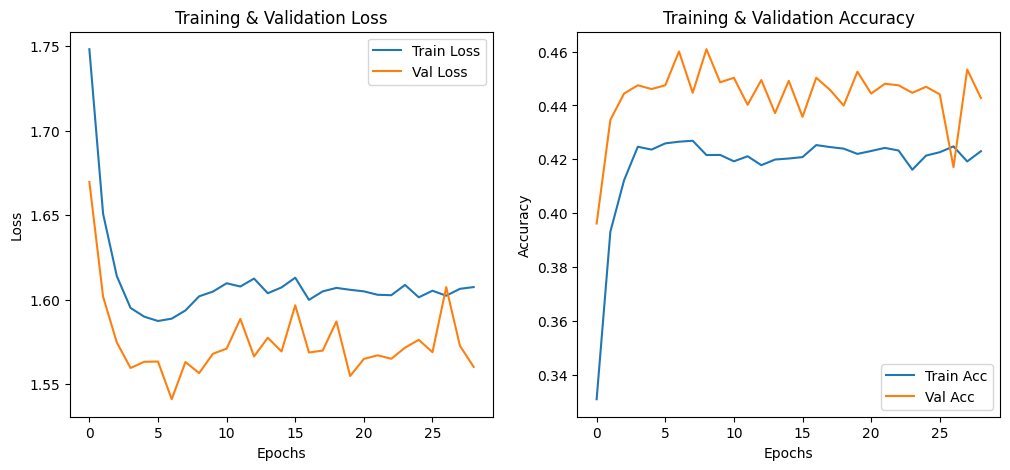

In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, patience=patience)

%%

In [28]:
def evaluate_model(model, dataloader, num_classes, device):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():  # No need to compute gradients
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get predicted class
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for actual, predicted in zip(y_true, y_pred):
        cm[actual, predicted] += 1
    return cm

Function to plot confusion matrix

In [29]:
def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(9, 8))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title("Confusion Matrix", fontsize=20)
    plt.colorbar()

    # Add text annotations
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
    plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
    plt.yticks(np.arange(len(class_labels)), class_labels)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("Actual Label", fontsize=14)
    plt.show()

%%

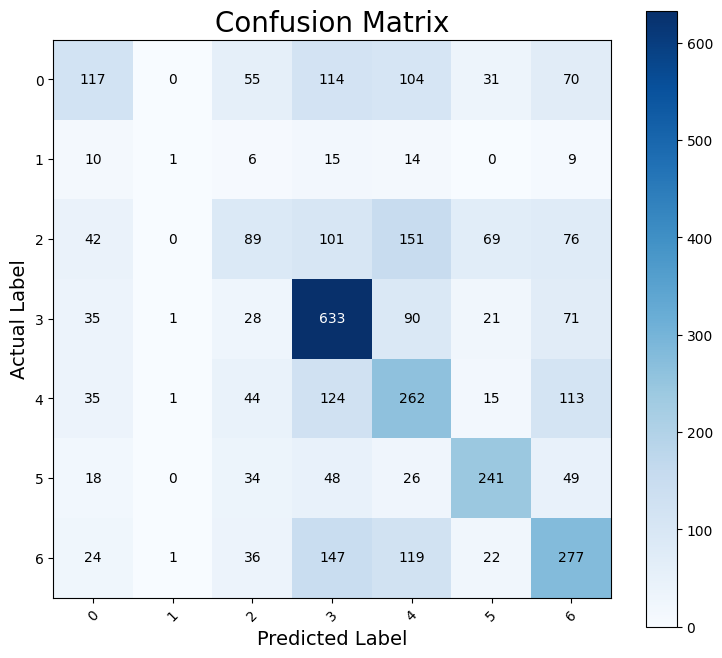

In [30]:
cm = evaluate_model(model_ft, dataloaders["test"], num_classes, device)
class_labels = [str(i) for i in range(num_classes)]  # Modify if class names are available
plot_confusion_matrix(cm, class_labels)

%%

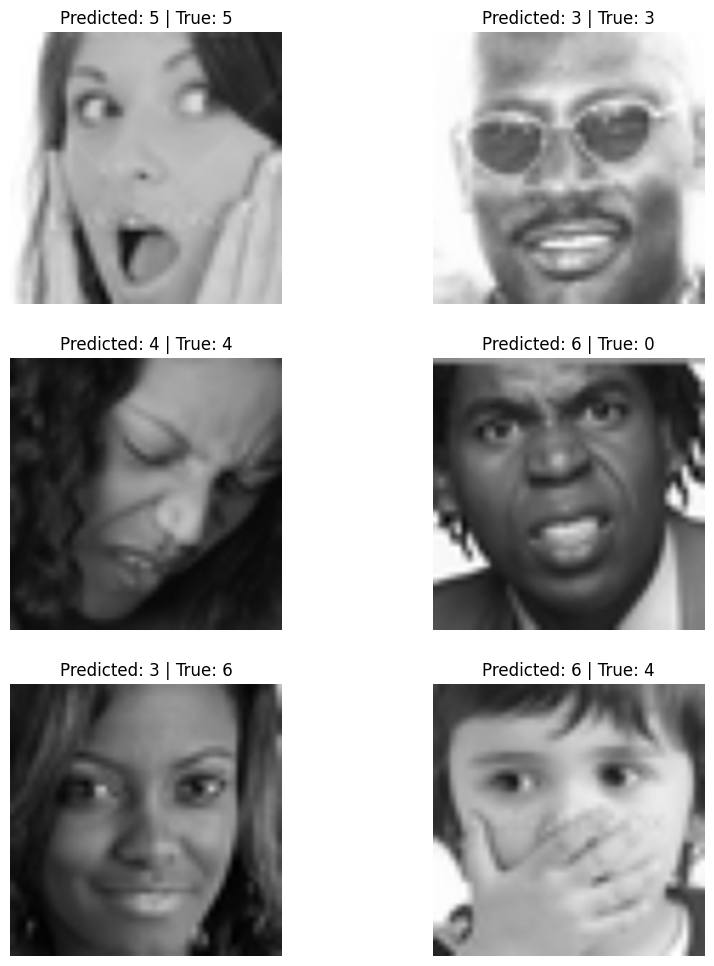

In [31]:
visualize_model(model_ft)

%% [markdown]<br>
Inference on test dataset<br>
==========================<br>
<br>
Use the trained model to make predictions on test dataset and visualize<br>
the predicted class labels along with the images.<br>


%%

In [32]:
import torch
import torchvision.models as models
import torch.nn as nn

Define the device

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Define the number of classes (7 in your case)

In [34]:
num_classes = 7

Initialize the EfficientNet-B0 model

In [35]:
model_ft = models.efficientnet_b0(weights=None)  # No pre-trained weights
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)

Move model to device

In [36]:
model_ft = model_ft.to(device)

Load the saved weights

In [37]:
model_path = "models/best_model.pth"  # Update this path if your model is saved elsewhere
model_ft.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

Set model to evaluation mode

In [38]:
model_ft.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [39]:
print("Model loaded successfully and ready for inference!")

Model loaded successfully and ready for inference!


%%

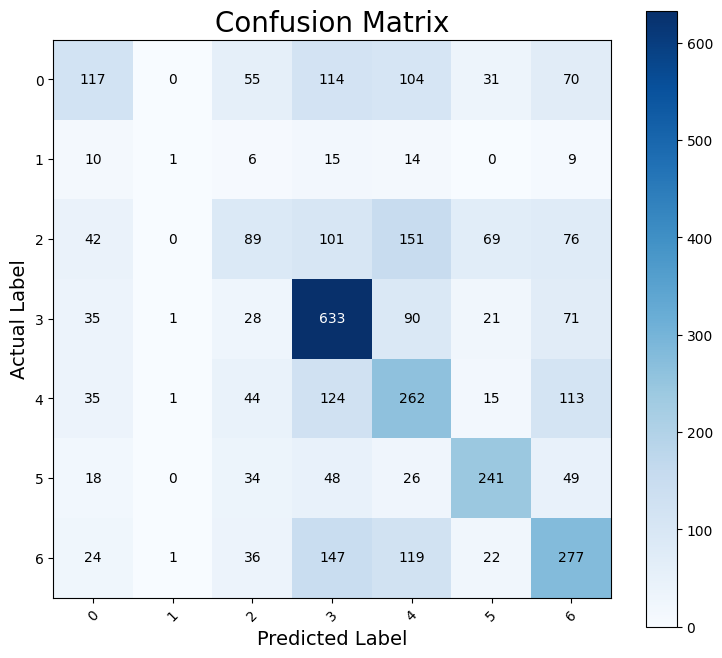

In [40]:
cm = evaluate_model(model_ft, dataloaders["test"], num_classes, device)
class_labels = [str(i) for i in range(num_classes)]  # Modify if class names are available
plot_confusion_matrix(cm, class_labels)

%% [markdown]<br>
Further Learning<br>
================<br>
<br>
If you would like to learn more about the applications of transfer<br>
learning, checkout our [Quantized Transfer Learning for Computer Vision<br>
Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).<br>
